In [1]:
import os
import tensorflow as tf
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kaggle
from definitions import *
import random

C:\Users\adell.j\anaconda3\envs\snr\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\adell.j\anaconda3\envs\snr\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\adell.j\anaconda3\envs\snr\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\adell.j\anaconda3\envs\snr\lib\site-packages\tensorflow\python\f

# Preprocess files from raw dataset

#### Data should be downloaded as it was done in data analysis ipynb file and it should be storred in "raw_data" folder and each subfolders should be called wih the class name and should consists files from corresponding class

### Create list of files and labels

In [2]:
subdirs = [f.name for f in os.scandir(raw_data_dir) if f.is_dir()]

files = []
for subdir in subdirs:
    subdir_path = os.path.join(raw_data_dir, subdir)
    files += [os.path.join(subdir_path, f.name) for f in os.scandir(subdir_path) if f.is_file()]

# Remove not images from dataset
not_jpg = [f for f in files if not f.endswith(".jpg")]
files = [file for file in files if file not in not_jpg]

# Sort files to maintain order
files = sorted(files)

labels = [file.split("\\")[-2] for file in files]

### Encode labels

In [3]:
label2index = dict((label, index) for index, label in enumerate(sorted(set(labels))))
encoded_labels = [label2index[label] for label in labels]

In [4]:
print(set(encoded_labels))
print(len(encoded_labels))

{0, 1, 2, 3}
11420


### Split files into training, testing and validation

In [5]:
NUMBER_OF_FILES  = len(files)
NUMBER_OF_LABELS = len(label2index)

In [6]:
from sklearn.model_selection import train_test_split

train_files, test_files, train_labels, test_labels = train_test_split(files,
                                                                      encoded_labels,
                                                                      test_size=TEST_SPLIT_FACTOR,
                                                                      random_state=1969)

train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=VAL_SPLIT_FACTOR,
                                                                    random_state=1969)

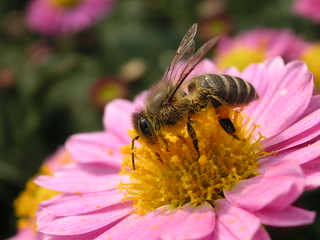

In [7]:
import IPython.display as display
display.display(display.Image('raw_data/bee/1240800_e5f2b40032_n.jpg'))

In [8]:
from collections import Counter
images_count_org = Counter()

# Checks how many images from each class we have
def countByClass(files):
    for file in files:
        label = file.split("\\")[-2]
        name = file.split("\\")[-1]

        images_count_org[label] += 1

    return images_count_org

### Data augmentation on: train_files, test_files, val_files

In [10]:
# TEST on one image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from random import randint

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def prepare_augmented_data(files_to_augment, output_dir):
    flow_counter = 0
    for img_path in files_to_augment: 

        img_path = img_path.replace("\\", "/")

        img = load_img(img_path)
        x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images

        label = img_path.split("/")[-2]

        if label == 'bee':
            augmentation_factor = 8
        elif label == 'wasp':
            augmentation_factor = 5
        elif label == 'other_insect':
            augmentation_factor = 10
        elif label == 'other_noinsect':
            augmentation_factor = 29
        
        # save orginal image 
        img.save(output_dir + "//" + label + "//" + img_path.split("/")[-1])
          
        prefix = randint(0, 10000)
        
        i = 0
        for batch in datagen.flow(x,
                                  batch_size=1,
                                  save_to_dir = output_dir + "//" + label,
                                  save_prefix=str(flow_counter) + "_" + str(prefix) + "__",
                                  save_format='jpg'):

            i += 1
            if i >=augmentation_factor:
                flow_counter += i
                break  # otherwise the generator would loop indefinitely
                
    return flow_counter

### Uncomment below if you want to generate augmented data
Make sure you have folders: "train_files", "test_files", "val_files" and in each of it empty subfolders: "bee", "wasp", "other_noinsect", "other_insect"

In [47]:
#counter_train = prepare_augmented_data(train_files, "train_files")
#counter_test = prepare_augmented_data(test_files, "test_files")
#counter_val = prepare_augmented_data(val_files, "val_files")

In [48]:
# Checks how many times flow functions was called
print(counter_train)
print(counter_test)
print(counter_val)

63869
19681
15838


### Prepare list with file names and correspondig labels for train test and val files from newly augmentet data

In [10]:
def prepare_augmented_split_data(data_dir):
    subdirs = [f.name for f in os.scandir(data_dir) if f.is_dir()]
 
    files = []
    for subdir in subdirs:
        subdir_path = os.path.join(data_dir, subdir)
        files += [os.path.join(subdir_path, f.name) for f in os.scandir(subdir_path) if f.is_file()]

    # Remove not images from dataset
    not_jpg = [f for f in files if not f.endswith(".jpg")]
    files = [file for file in files if file not in not_jpg]

    # Sort files to maintain order
    #files = sorted(files)
    random.shuffle(files)
    
    labels = [file.split("\\")[-2] for file in files]
    
    label2index = dict((label, index) for index, label in enumerate(sorted(set(labels))))
    encoded_labels = [label2index[label] for label in labels]
    
    print(encoded_labels[0])
    return files, encoded_labels

In [11]:
train_files, train_labels = prepare_augmented_split_data("train_files")
test_files, test_labels = prepare_augmented_split_data("test_files")
val_files, val_labels = prepare_augmented_split_data("val_files")

0
0
1


In [12]:
print(train_labels[0])
print(type(train_labels[0]))

0
<class 'int'>


In [13]:
train_labels = tf.keras.utils.to_categorical(train_labels, 4, dtype='int32')
test_labels = tf.keras.utils.to_categorical(test_labels, 4, dtype='int32')
val_labels = tf.keras.utils.to_categorical(val_labels, 4, dtype='int32')

In [14]:
print(train_labels[0])
print(type(train_labels[0][0]))
print(train_labels[0][0])

[1 0 0 0]
<class 'numpy.int32'>
1


In [15]:
#print(type(train_labels))
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)
#print(train_labels[0])
#x = tf.constant(train_labels, dtype=tf.float32)
#print(x)
print(train_labels.shape[0] + test_labels.shape[0] + val_labels.shape[0] )

(71142, 4)
(21949, 4)
(17659, 4)
110750


### Prepare images in dataset

In [16]:
# scale all images to 224x224 - default image size in vgg19 nn model
def prepare_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(
        image,
        optimize_size=True,
        x_density=96,
        y_density=96
    )

    return image

def load_and_prepare_image(path):
    image = tf.io.read_file(path)
    return prepare_image(image)

In [17]:
# Save new labes casted to int32

#train_labels_file = output_datasets_dir + '/' + 'int_train_labels.tfrec'
#test_labels_file  = output_datasets_dir + '/' +  'int_test_labels.tfrec'
#val_labels_file   = output_datasets_dir + '/' +   'int_val_labels.tfrec'

train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)
test_labels_ds  = tf.data.Dataset.from_tensor_slices(test_labels)
val_labels_ds   = tf.data.Dataset.from_tensor_slices(val_labels)

train_labels_ds = train_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
test_labels_ds  =  test_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
val_labels_ds   =   val_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)

train_writer = tf.data.experimental.TFRecordWriter(train_labels_file)
test_writer  = tf.data.experimental.TFRecordWriter( test_labels_file)
val_writer   = tf.data.experimental.TFRecordWriter(  val_labels_file)

train_writer.write(train_labels_ds)
test_writer. write(test_labels_ds)
val_writer.  write(val_labels_ds)


# Create TFRecord files

### Create split datasets

In [19]:
train_images_ds = tf.data.Dataset.from_tensor_slices(train_files)
test_images_ds  = tf.data.Dataset.from_tensor_slices(test_files)
val_images_ds   = tf.data.Dataset.from_tensor_slices(val_files)

train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)
test_labels_ds  = tf.data.Dataset.from_tensor_slices(test_labels)
val_labels_ds   = tf.data.Dataset.from_tensor_slices(val_labels)

### Apply preprocessing to images datasets

In [20]:
train_images_ds = train_images_ds.map(load_and_prepare_image, num_parallel_calls=4)
test_images_ds  =  test_images_ds.map(load_and_prepare_image, num_parallel_calls=4)
val_images_ds   =   val_images_ds.map(load_and_prepare_image, num_parallel_calls=4)

### Save images datasets to binary files

In [21]:
train_images_ds = train_images_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
test_images_ds  =  test_images_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
val_images_ds   =   val_images_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)

train_writer = tf.data.experimental.TFRecordWriter(train_images_file)
test_writer  = tf.data.experimental.TFRecordWriter( test_images_file)
val_writer   = tf.data.experimental.TFRecordWriter(  val_images_file)

# <span style="color:red">Do not use the commented code below!!!</span>
### ...unless you're 100% sure you know why are you doing this
This will override our dataset and it will be no longer consistent with a previous version

In [22]:
 train_writer.write(train_images_ds)
 test_writer.write(test_images_ds)
 val_writer.write(val_images_ds)

### Save labels datasets to binary files

In [23]:
train_labels_ds = train_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
test_labels_ds  =  test_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)
val_labels_ds   =   val_labels_ds.map(tf.io.serialize_tensor, num_parallel_calls=4)

train_writer = tf.data.experimental.TFRecordWriter(train_labels_file)
test_writer  = tf.data.experimental.TFRecordWriter( test_labels_file)
val_writer   = tf.data.experimental.TFRecordWriter(  val_labels_file)

# <span style="color:red">Do not use the commented code below!!!</span>
### ...unless you're 100% sure you know why are you doing this
This will override our dataset and it will be no longer consistent with a previous version

In [24]:
train_writer.write(train_labels_ds)
test_writer. write(test_labels_ds)
val_writer.  write(val_labels_ds)

In [25]:
from preprocessing import load_datasets, time_footprint, load_labels_datasets, load_images_datasets

train_ds, test_ds, val_ds = load_datasets()

In [26]:
print(train_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>


In [29]:
for images, labels in train_ds.as_numpy_iterator():
    print(labels)
    break

AttributeError: 'PrefetchDataset' object has no attribute 'as_numpy_iterator'